# QCoDeS Example with Standford Research SR86x Lock-in Amplifier with Buffered Readout

This notebook provides a code example of usage of the driver for Standford Research SR86x lock-in amplifier. Special attention is given to reading the captured data from the lock-in's internal buffer.

This notebook covers several capturing modes including starting capture at trigger, and capturing one sample per trigger. For the purpose of this example, a Tektronix AWG5208 will be used to send trigger signals. One can also use `qcodes.instrument_drivers.QuTech.IVVI` with its `trigger` method, or else.

## Setting up infrastructure for the examples

### Imports

In [1]:
%matplotlib notebook

# Useful utilities
from pprint import pprint  # for pretty printing lists and dictionaries

import matplotlib.pyplot as plt
import numpy

# Drivers
from qcodes.instrument_drivers.stanford_research import SR860
from qcodes.instrument_drivers.tektronix import (
    TektronixAWG5208,  # used for sending trigger signals
)

# QCoDeS

### Initialize the driver

In [3]:
lockin = SR860("lockin", "GPIB0::4::INSTR")

Connected to: Stanford_Research_Systems SR860 (serial:003223, firmware:V1.47) in 0.25s


## Basics of reading values from the lock-in

Lock-in amplifier measures a number of values. The most frequently used ones are available in the driver directly as QCODES parameters:

In [4]:
print(f"X = { lockin.X() }")
print(f"Y = { lockin.Y() }")
print(f"R = { lockin.R() }")
print(f"P = { lockin.P() }")

X = 3.1690581181e-07
Y = 2.9734803775e-07
R = 4.2155235747e-07
P = 45.936515808


Actually, the full list of values (or 'parameters', not to be confused with QCODES parameters) that the lock-in amplifier measures is available in the following dictionary (refer to the page 132 of the instrument's manual for more information):

In [5]:
pprint(list(lockin.PARAMETER_NAMES.keys()))

['X',
 'Y',
 'R',
 'P',
 'aux_in1',
 'aux_in2',
 'aux_in3',
 'aux_in4',
 'Xnoise',
 'Ynoise',
 'aux_out1',
 'aux_out2',
 'phase',
 'amplitude',
 'sine_outdc',
 'frequency',
 'frequency_ext']


Use the `get_values` method of the driver to obtain values of 2 or 3 of those parameters. The values that are returned by this method are guaranteed to be coming from the same measurement, as opposed to requesting values sequentially by calling `lockin.X()` and then `lockin.Y()`. The method returns a tuple of values.

In [7]:
lockin.get_values("X", "Y", "Xnoise")

(-2.1813903572e-07, 1.6225968125e-07, 3.1462531069e-07)

In [8]:
lockin.get_values("R", "P")

(2.696416459e-07, 152.20687866)

## Data channels

Lock-in amplifier has a notion of data channels. Each data channel can be assigned to a measured parameter mentioned above. Each data channel is being displayed on the insturment's screen, and has a corresponding color.

Let's list the data channels using the `data_channels` list:

In [10]:
msg = "Lock-in amplifier has the following data channels:\n"
msg += "\n".join([f"{dch.cmd_id_name} ({dch.color})" for dch in lockin.data_channels])
print(msg)

Lock-in amplifier has the following data channels:
DAT1 (green)
DAT2 (blue)
DAT3 (yellow)
DAT4 (orange)


These channels are also accessible individually from the lock-in amplifier driver instance with `data_channel_<i>` attributes.

Each of the channels has a `color`, `cmd_id` that is used in VISA commands, and `cmd_id_name` that can be (but is not) used in VISA commands, and is just there for reference.

Most importantly, each data channel has an `assigned_parameter` to it. The available parameter are coming from the same list of parameters from above.

In [13]:
lockin.data_channel_3.assigned_parameter("aux_in3")
lockin.data_channel_3.assigned_parameter()

'aux_in3'

The main feature of the data channels is that the lock-in amplifier has commands to retrieve all of their values at once. This feature is similar to `get_values` method, but instead of specifying the parameter names, the values of the data channels are returned.

`get_data_channels_values` method returns a tuple of the values of the data channels.

In [15]:
lockin.get_data_channels_values()

(-1.3243408148e-07, -1.4647376645e-07, -0.00053787231445, -132.11825562)

In order to see which are the assigned parameters for all the data channels, `get_data_channels_parameters` method can be used. Note that this method has a keyword argument `query_instrument` that allows you to choose not to query the values from the instrument in order to save time on VISA communication.

In [18]:
lockin.get_data_channels_parameters()

('X', 'Y', 'aux_in3', 'P')

Finally, a convenience method available that returns a dictionary of data channels assigned parameters with the associated values. Note that this method also has a keyword argument `requery_names` that allows you to choose whether the assigned parameter names are queried from the instrument. In this case, by default the names are not queried.

In [21]:
lockin.get_data_channels_dict()

{'P': -95.362594604,
 'X': -3.9464794099e-08,
 'Y': -4.204223103e-07,
 'aux_in3': -0.00045776367188}

## Setting up for the buffer readout examples

### Set capture configuration

The lock-in needs to know what values shall be captured. Let's capture "X" and "Y".

In [3]:
lockin.input_config("a")
lockin.buffer.capture_config("X,Y")

### Set lock-in parameters

Let's tune the lock-in so that it measures something reasonable. Let's not attach any cables to the lock-in, and try to perform a measurement of the noise that the instrument is capturing. The most obvious noise source is the grid, 50 Hz, hence let's set the frequency of the lock-in amplifier somewhere below that frequency to see modulations instead of a flat value that we could have measured at 50 Hz.

In [4]:
lockin.input_range(10e-3)  # V

lockin.sensitivity(500e-3)  # V
lockin.frequency(27.3645)  # Hz
lockin.time_constant(10e-3)  # s

### Initialize AWG

In [5]:
awg = TektronixAWG5208("awg", address="TCPIP0::169.254.254.84::inst0::INSTR")

Connected to: TEKTRONIX AWG5208 (serial:B020205, firmware:FV:6.0.0242.0) in 0.12s


## One-shot immediate capture

We are going to capture a number of data points (also referred to as samples) at a capture rate, retrieve data from the buffer, and plot it.

### Set capture rate

The lock-in will be capturing data at some rate. Let's set this rate:

In [6]:
lockin.buffer.capture_rate(1220.7)
print(f"Capture rate is set to {lockin.buffer.capture_rate()}")

Capture rate is set to 1220.703125


In case you want to capture data at a maximum possible rate, but you do not remember the value of the maximum possible capture rate, the convenient `set_capture_rate_to_maximum` method can be used: 

In [7]:
lockin.buffer.set_capture_rate_to_maximum()
print(f"Capture rate is set to its maximum: {lockin.buffer.capture_rate()}")

Capture rate is set to its maximum: 39062.5


### Capture data

Now let's acquire some data:

In [8]:
sample_count = 678

# Set the capture length (which is a portion of the buffer size)
# to fit the number of samples that we want to capture.
# For more information about the maximum buffer size,
# and other buffer-related properties, refer to the instrument manual.
lockin.buffer.set_capture_length_to_fit_samples(sample_count)

# Start capturing data immediately,
# and without overwriting the buffer in case it gets full.
# For more information about the capture modes, refer to the instrument manual.
lockin.buffer.start_capture("ONE", "IMM")

# We call this blocking method to wait until
# the requested number of samples is captured.
lockin.buffer.wait_until_samples_captured(sample_count)

# Stop capturing.
lockin.buffer.stop_capture()

# Retrieve the data from the buffer.
# The returned data is a dictionary where keys are names of the variables
# from the capture config, and values are the captured values.
data = lockin.buffer.get_capture_data(sample_count)

print(f"The number of acquired X data points is {len(data['X'])}")
print(f"The number of acquired Y data points is {len(data['Y'])}")

The number of acquired X data points is 678
The number of acquired Y data points is 678


For convenience, the measurement code from above is encapsulated into a convenient `capture_samples` method of the lock-in buffer:

In [9]:
data = lockin.buffer.capture_samples(sample_count)

Let's plot the captured data:

<IPython.core.display.Javascript object>


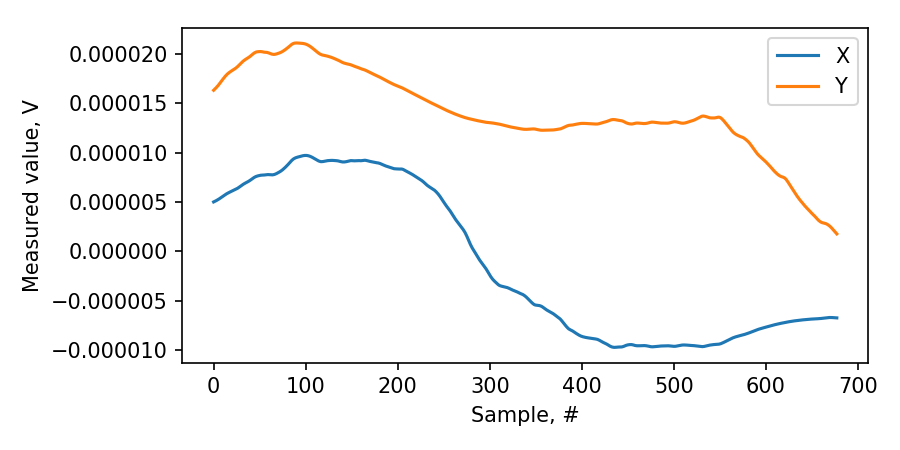

In [10]:
# Set the figure size to be more convenient then the defaults
fig = plt.figure(figsize=(6, 3))

# plot values of all the captured variables
for var_name in data:
    plt.plot(data[var_name], label=var_name)
plt.xlabel("Sample, #")
plt.ylabel("Measured value, V")

plt.legend()  # show legend
plt.tight_layout()  # adjust the figure so that all the labels fit

### Access captured data via Parameter interface

The SR86x driver has the capture variables (X, Y, R, theta) as QCoDeS Parameters in the buffer. This allows to use `lockin.buffer.X.get()` syntax to retrieve the captured data. Beware that it is necessary that the `lockin.buffer.get_capture_data` method has been called before retrieving data via Parameters (in other words, `lockin.buffer.X.get()` does not initiate a new capture, it just returns the latest captured data).

For the sake of demonstration, let's plot the captured data again, but now using the Parameters (notice that this plot contains the same data as the one above):

<IPython.core.display.Javascript object>


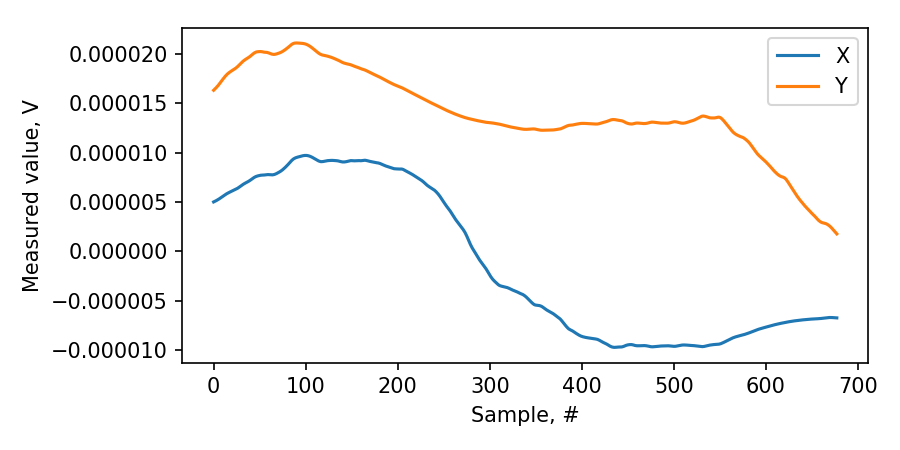

In [11]:
# Set the figure size to be more convenient then the defaults
fig = plt.figure(figsize=(6, 3))

# plot values of all the captured variables
plt.plot(lockin.buffer.X.get(), label="X")
plt.plot(lockin.buffer.Y.get(), label="Y")
plt.xlabel("Sample, #")
plt.ylabel("Measured value, V")

plt.legend()  # show legend
plt.tight_layout()  # adjust the figure so that all the labels fit

## Capture after trigger is sent

In this example, we are going to initiate data capture via a trigger signal. Lock-in amplifier SR860 reacts on the falling edge of the trigger signal. We are going to use a marker of an AWG channel to send the trigger signal.

### Setup AWG to emit a simple trigger signal

The following code is specific to the AWG5208 that is used in this example. One is welcome to use waveform generation frameworks like `broadbean` rather than the low-level kind of interaction with the AWG driver below.

In [12]:
awg.sample_rate(3000)  # S/s

# Create a waveform where the analog channel plays 0s,
# while the marker channel plays a falling edge from 1 to 0.
waveform_ch1 = numpy.zeros((2, 3000))  # the waveform will have a length of 1s
# (3000 samples for 3000 S/s sample rate)
waveform_ch1[1, :-1500] = 1  # falling from 1 to 0 (a.u.),
# at 0.5s after the start of the waveform
elements = numpy.array([waveform_ch1])  # we only have one element in the sequence
waveforms = numpy.array([elements])  # we will use only 1 channel

# Create a sequence file from the "waveform" array
seq_name = "single_trigger_marker_1"
seqx = awg.makeSEQXFile(
    trig_waits=[0],
    nreps=[1],
    event_jumps=[0],
    event_jump_to=[0],
    go_to=[1],
    wfms=waveforms,
    amplitudes=[1.0],
    seqname=seq_name,
)

# Send the sequence file to AWG internal disk
seqx_file_name = seq_name + ".seqx"
awg.sendSEQXFile(seqx, seqx_file_name)

awg.clearSequenceList()
awg.clearWaveformList()

# Load the sequence file from AWG internal disk
awg.loadSEQXFile(seqx_file_name)

# Full resolution of the AWG channel is 16 bits for AWG5208,
# but we take 1 bit for the marker channel
awg.ch1.resolution = 16 - 1

awg.ch1.awg_amplitude(1)  # V

# Load a particular sequence to the channel
awg.ch1.setSequenceTrack(seq_name, 0)
# Assign a loaded waveform to the channel
awg.ch1.setWaveform(awg.waveformList[0])

# Set the marker's high as high as possible
# so that the lock-in detects the falling edge
awg.ch1.marker1_high(1.75)  # V
awg.ch1.marker1_low(0)  # V

awg.ch1.state(1)  # turns the channel "on"

### Set capture rate

Even though we will be triggering the capture via trigger, the lock-in will still be capturing data at some rate. Let's set this rate:

In [13]:
lockin.buffer.capture_rate(4882.8)

### Capture data

In [14]:
sample_count = 321

# Set the capture length (which is a portion of the buffer size)
# to fit the number of samples that we want to acquire.
# For more information about the maximum buffer size,
# and other buffer-related properties, refer to the instrument manual.
lockin.buffer.set_capture_length_to_fit_samples(sample_count)

# Start capturing data when a trigger signal is recieved,
# and without overwriting the buffer in case it gets full.
# This basically arms the lock-in amplifier.
# For more information about the capture modes, refer to the instrument manual.
lockin.buffer.start_capture("ONE", "TRIG")

# Play the AWG sequence that contains the trigger signal.
# Basically, this call indirectly triggers the lock-in to start capturing data.
awg.play()

# We call this blocking function to wait
# until the requested number of samples is captured.
lockin.buffer.wait_until_samples_captured(sample_count)

# Stop capturing.
lockin.buffer.stop_capture()

# Stop the AWG sequence playback
awg.stop()

# Retrieve the data from the buffer.
# The returned data is a dictionary where keys are names of the variables
# from the capture config, and values are the captured values.
data = lockin.buffer.get_capture_data(sample_count)

print(f"The number of acquired X data points is {len(data['X'])}")
print(f"The number of acquired Y data points is {len(data['Y'])}")

The number of acquired X data points is 321
The number of acquired Y data points is 321


For convenience, the measurement code from above is encapsulated into a method of the lock-in buffer `capture_samples_after_trigger`:

In [15]:
try:
    # Note the second argument - it is a callable
    # that is responsible for emitting the trigger signal
    data = lockin.buffer.capture_samples_after_trigger(sample_count, awg.play)

finally:  # the try-finally block is here purely
    # to ensure that the AWG is stopped anyway
    awg.stop()

Let's plot the captured data:

<IPython.core.display.Javascript object>


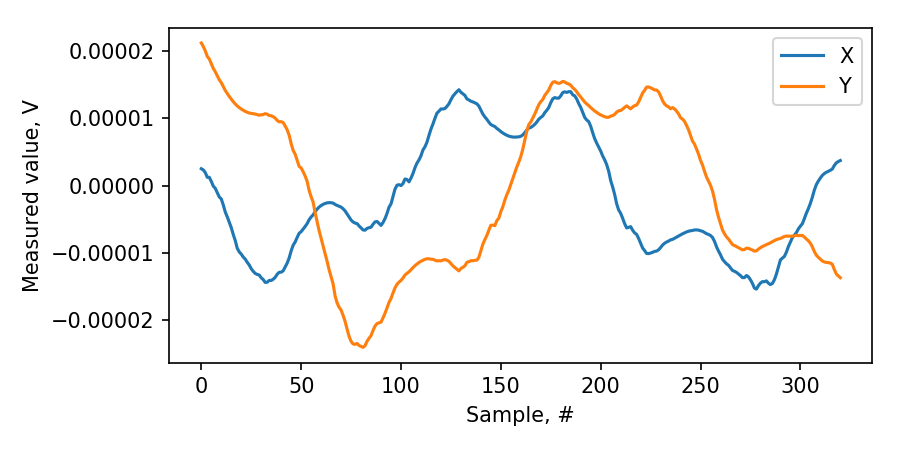

In [16]:
# Set the figure size to be more convenient then the defaults
fig = plt.figure(figsize=(6, 3))

# plot values of all the captured variables
for var_name in data:
    plt.plot(data[var_name], label=var_name)
plt.xlabel("Sample, #")
plt.ylabel("Measured value, V")

plt.legend()  # show legend
plt.tight_layout()  # adjust the figure so that all the labels fit

## Capturing one sample per trigger

In this example, we are going to initiate data capture that will capture one sample per received trigger signal. Lock-in amplifier SR860 reacts on the falling edge of the trigger signal. We are going to use a marker of an AWG channel to send the triggers.

### Setup AWG to emit a trigger pulse train

The following code is specific to the AWG5208 that is used in this example. One is welcome to use waveform generation frameworks like `broadbean` rather than the low-level kind of interaction with the AWG driver below.

In [17]:
awg.sample_rate(3000)  # S/s

# Create a waveform where the analog channel plays 0s,
# while the marker channel plays
# a number of falling edges from 1 to 0.

n_samples_in_waveform = 3000
# the waveform will have a length of 1s
waveform_ch1 = numpy.zeros((2, n_samples_in_waveform))

n_trigger_pulses = 100
waveform_ch1[1, :] = numpy.tile(
    numpy.concatenate(
        (  # this defines a single trigger pulse
            # that represents a falling edge
            # first half a single pulse is high (1s)
            numpy.ones(n_samples_in_waveform // n_trigger_pulses // 2),
            # second half a single pulse is low (0s)
            numpy.zeros(n_samples_in_waveform // n_trigger_pulses // 2),
        )
    ),
    n_trigger_pulses,
)  # falling from 1 to 0 (a.u.) every 0.01s after the start of the waveform

elements = numpy.array([waveform_ch1])  # we only have one element in the sequence
waveforms = numpy.array([elements])  # we will use only 1 channel

# Create a sequence file from the "waveform" array
seq_name = "single_trigger_marker_1"
seqx = awg.makeSEQXFile(
    trig_waits=[0],
    nreps=[1],
    event_jumps=[0],
    event_jump_to=[0],
    go_to=[1],
    wfms=waveforms,
    amplitudes=[1.0],
    seqname=seq_name,
)

# Send the sequence file to AWG internal disk
seqx_file_name = seq_name + ".seqx"
awg.sendSEQXFile(seqx, seqx_file_name)

awg.clearSequenceList()
awg.clearWaveformList()

# Load the sequence file
awg.loadSEQXFile(seqx_file_name)

# Full resolution of the AWG channel is 16 bits for AWG5208,
# but we take 1 bit for the marker channel
awg.ch1.resolution = 16 - 1

awg.ch1.awg_amplitude(1)  # V
# Load a particular sequence to the channel
awg.ch1.setSequenceTrack(seq_name, 0)
# Assign a waveform to the channel
awg.ch1.setWaveform(awg.waveformList[0])

# Set the marker's high as high as possible
# so that the lock-in detects the falling edge
awg.ch1.marker1_high(1.75)  # V
awg.ch1.marker1_low(0)  # V

awg.ch1.state(1)  # turns the channel "on"

### Capture data

In [18]:
sample_count = n_trigger_pulses

# Set the capture length (which is a portion of the buffer size)
# to fit the number of samples that we want to acquire.
# For more information about the maximum buffer size,
# and other buffer-related properties, refer to the instrument manual.
lockin.buffer.set_capture_length_to_fit_samples(sample_count)

# Start capturing data, and capture one sample per each received trigger signal.
# This basically arms the lock-in amplifier.
# For more information about the capture modes, refer to the instrument manual.
lockin.buffer.start_capture("ONE", "TRIG")

# Play the AWG sequence that contains the trigger pulses train.
awg.play()

# We call this blocking function to wait
# until the requested number of samples is captured.
lockin.buffer.wait_until_samples_captured(sample_count)

# Stop capturing.
lockin.buffer.stop_capture()

# Stop the AWG sequence playback
awg.stop()

# Retrieve the data from the buffer.
# The returned data is a dictionary where keys are names of the variables
# from the capture config, and values are the captured values.
data = lockin.buffer.get_capture_data(sample_count)

print(f"The number of acquired X data points is {len(data['X'])}")
print(f"The number of acquired Y data points is {len(data['Y'])}")

The number of acquired X data points is 100
The number of acquired Y data points is 100


For convenience, the measurement code from above is encapsulated into a method of the lock-in buffer `capture_one_sample_per_trigger`:

In [19]:
try:
    # Note the second argument - it is a callable
    # that is responsible for starting the trigger pulse train
    data = lockin.buffer.capture_one_sample_per_trigger(sample_count, awg.play)

finally:  # the try-finally block is here purely
    # to ensure that the AWG is stopped anyway
    awg.stop()

Let's plot the captured data:

<IPython.core.display.Javascript object>


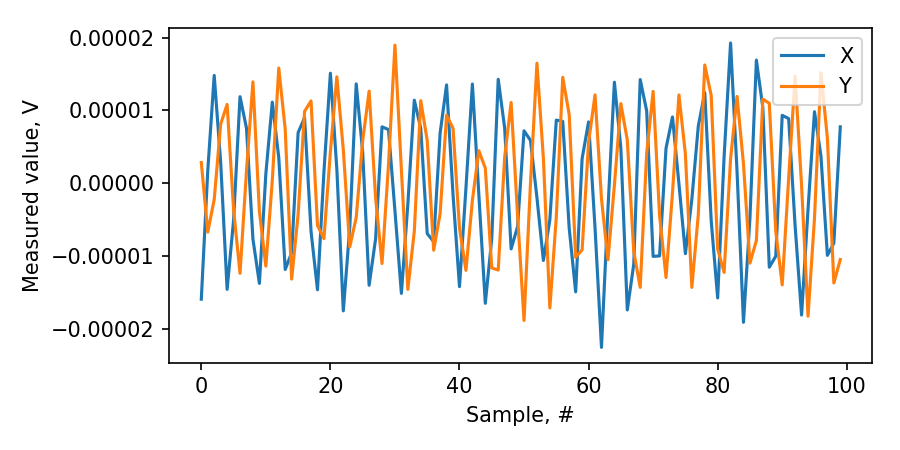

In [20]:
# Set the figure size to be more convenient then the defaults
fig = plt.figure(figsize=(6, 3))

# plot values of all the captured variables
for var_name in data:
    plt.plot(data[var_name], label=var_name)
plt.xlabel("Sample, #")
plt.ylabel("Measured value, V")

plt.legend()  # show legend
plt.tight_layout()  # adjust the figure so that all the labels fit